In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
res = {}
res["data"] = json.load(open("../out/baseline/data_2016.json"))

In [3]:
data = open("../data/lumi2016.csv")
int_lumi = 0
for l in data.readlines():
    if "STABLE" in l:
        x = float(l.split(",")[6])
        int_lumi += x

In [4]:
#int_lumi = res_data["int_lumi"]

In [5]:
res["dy"] = json.load(open("../out/baseline/dy_2016.json"))
res["ggh"] = json.load(open("../out/baseline/ggh_2016.json"))

In [6]:
from collections import OrderedDict

In [7]:
def create_variated_histos(hdict, baseline="nominal", variations=["puWeight", "jes", "jer"]):
    if not baseline in hdict.keys():
        raise KeyError("baseline histogram missing")
    hbase = hdict[baseline]
    ret = OrderedDict()
    ret["nominal"] = hbase
    for variation in variations:
        for vdir in ["up", "down"]:
            sname = "{0}__{1}".format(variation, vdir)
            ret[sname] = hdict.get(sname, hbase)
    return ret

In [197]:
def create_datacard(dict_procs, parameter_name, processes, signal_processes, histname, baseline, variations):
    ret = OrderedDict()
    for proc in processes:
        rr = dict_procs[proc][parameter_name][histname]
        _variations = variations
        if proc == "data":
            _variations = []
        vr = create_variated_histos(rr, baseline, _variations)
        for k, v in vr.items():
            rk = "{0}__{2}".format(proc, histname, k)
            if rk == "data__nominal":
                rk = "data_obs"
            rk = rk.replace("__nominal", "")
            ret[rk] = v
    return ret

In [198]:
import uproot
import uproot_methods
def save_datacard(dc, outfile):
    fi = uproot.recreate(outfile)
    for histo_name in dc.keys():
        fi[histo_name] = to_th1(dc[histo_name], histo_name)
    fi.close()

In [214]:
def create_datacard_combine(
    dict_procs, parameter_name, processes, signal_processes, histname, baseline, variations, txtfile_name):
    
    dc = create_datacard(dict_procs, parameter_name, processes, signal_processes, histname, baseline, variations)
    rootfile_name = "{0}.root".format(histname)
    
    save_datacard(dc, rootfile_name)
    
    processes.pop(processes.index("data"))
    shape_uncertainties = {v: 1.0 for v in variations}
    cat = Category(
        name=histname,
        processes=processes, signal_processes=signal_processes,
        common_shape_uncertainties=shape_uncertainties)
    
    print(cat.shape_uncertainties)
    categories = [cat]
    event_counts = {}
    for cat in categories:
        event_counts[cat.full_name] = {}
        for proc in cat.processes:
            event_counts[cat.full_name][proc] = np.sum(dict_procs[proc][parameter_name][histname][baseline]["contents"])

    filenames = {}
    for cat in categories:
        filenames[cat.full_name] = rootfile_name

    PrintDatacard(categories, event_counts, filenames, txtfile_name)

In [215]:
from uproot_methods.classes.TH1 import Methods, _histtype, from_numpy

def to_th1(hdict, name):
    content = np.array(hdict["contents"])
    content_w2 = np.array(hdict["contents_w2"])
    edges = np.array(hdict["edges"])
    
    #remove inf/nan just in case
    content[np.isinf(content)] = 0
    content_w2[np.isinf(content_w2)] = 0

    content[np.isnan(content)] = 0
    content_w2[np.isnan(content_w2)] = 0
    
    #update the error bars
    centers = (edges[:-1] + edges[1:]) / 2.0
    th1 = from_numpy((content, edges))
    th1._fName = name
    th1._fSumw2 = np.array(hdict["contents_w2"])
    th1._fTsumw2 = np.array(hdict["contents_w2"]).sum()
    th1._fTsumwx2 = np.array(hdict["contents_w2"] * centers).sum()

    return th1

In [216]:
class Category:
    def __init__(self, **kwargs):
        self.name = kwargs.get("name")
        self.full_name = self.name
        self.rebin = kwargs.get("rebin", 1)
        self.do_limit = kwargs.get("do_limit", True)

        self.scale_uncertainties = kwargs.get("scale_uncertainties", {})

        self.cuts = kwargs.get("cuts", [])

        self.processes = kwargs.get("processes", [])
        self.data_processes = kwargs.get("data_processes", [])
        self.signal_processes = kwargs.get("signal_processes", [])
        
        #[process][systematic] -> scale factor in datacard
        self.shape_uncertainties = {}
        self.scale_uncertainties = {}

        #[syst] -> scale factor, common for all processes
        common_shape_uncertainties = kwargs.get("common_shape_uncertainties", {})
        common_scale_uncertainties = kwargs.get("common_scale_uncertainties", {})
        for proc in self.processes:
            self.shape_uncertainties[proc] = {}
            self.scale_uncertainties[proc] = {}
            for systname, systval in common_shape_uncertainties.items():
                self.shape_uncertainties[proc][systname] = systval
            for systname, systval in common_scale_uncertainties.items():
                self.scale_uncertainties[proc][systname] = systval

        #Load the process-dependent shape uncertainties
        self.proc_shape_uncertainties = kwargs.get("shape_uncertainties", {})
        for proc, v in self.proc_shape_uncertainties.items():
            self.shape_uncertainties[proc].update(v)

def PrintDatacard(categories, event_counts, filenames, ofname):
    dcof = open(ofname, "w")
    
    number_of_bins = len(categories)
    number_of_backgrounds = 0
    
    backgrounds = []    
    for cat in categories:
        for proc in cat.processes:
            if proc not in cat.signal_processes:
                backgrounds += [proc]
    
    backgrounds = set(backgrounds)
    number_of_backgrounds = len(backgrounds)
    analysis_categories = list(set([c.full_name for c in categories]))


    dcof.write("imax {0}\n".format(number_of_bins))
    dcof.write("jmax {0}\n".format(number_of_backgrounds))
    dcof.write("kmax *\n")
    dcof.write("---------------\n")

    for cat in categories:
#old format
#        dcof.write("shapes * {0} {1} $PROCESS__$CHANNEL $PROCESS__$CHANNEL__$SYSTEMATIC\n".format(
        dcof.write("shapes * {0} {1} $PROCESS $PROCESS__$SYSTEMATIC\n".format(
            cat.full_name,
            os.path.basename(filenames[cat.full_name])
        ))

    dcof.write("---------------\n")

    dcof.write("bin\t" +  "\t".join(analysis_categories) + "\n")
    dcof.write("observation\t" + "\t".join("-1" for _ in analysis_categories) + "\n")
    dcof.write("---------------\n")

    bins        = []
    processes_0 = []
    processes_1 = []
    rates       = []

    for cat in categories:
        for i_sample, sample in enumerate(cat.processes):
            bins.append(cat.full_name)
            processes_0.append(sample)
            if sample in cat.signal_processes:
                i_sample = -i_sample
            processes_1.append(str(i_sample))
            rates.append("{0:.2f}".format(event_counts[cat.full_name][sample]))
    
    #Write process lines (names and IDs)
    dcof.write("bin\t"+"\t".join(bins)+"\n")
    dcof.write("process\t"+"\t".join(processes_0)+"\n")
    dcof.write("process\t"+"\t".join(processes_1)+"\n")
    dcof.write("rate\t"+"\t".join(rates)+"\n")
    dcof.write("---------------\n")

    # Gather all shape uncerainties
    all_shape_uncerts = []
    all_scale_uncerts = []
    for cat in categories:
        for proc in cat.processes:
            all_shape_uncerts.extend(cat.shape_uncertainties[proc].keys())
            all_scale_uncerts.extend(cat.scale_uncertainties[proc].keys())
    # Uniquify
    all_shape_uncerts = sorted(list(set(all_shape_uncerts)))
    all_scale_uncerts = sorted(list(set(all_scale_uncerts)))

    #print out shape uncertainties
    for syst in all_shape_uncerts:
        dcof.write(syst + "\t shape \t")
        for cat in categories:
            for proc in cat.processes:
                if (proc in cat.shape_uncertainties.keys() and
                    syst in cat.shape_uncertainties[proc].keys()):
                    dcof.write(str(cat.shape_uncertainties[proc][syst]))
                else:
                    dcof.write("-")
                dcof.write("\t")
        dcof.write("\n")


    #print out scale uncertainties
    for syst in all_scale_uncerts:
        dcof.write(syst + "\t lnN \t")
        for cat in categories:
            for proc in cat.processes:
                if (proc in cat.scale_uncertainties.keys() and
                    syst in cat.scale_uncertainties[proc].keys()):
                    dcof.write(str(cat.scale_uncertainties[proc][syst]))
                else:
                    dcof.write("-")
                dcof.write("\t")
        dcof.write("\n")

    #create nuisance groups for easy manipulation and freezing
    nuisance_groups = {}
    for nuisance_group, nuisances in nuisance_groups.items():
        good_nuisances = []
        for nui in nuisances:
            good_nuisances += [nui]
        dcof.write("{0} group = {1}\n".format(nuisance_group, " ".join(good_nuisances)))
    
    #dcof.write("* autoMCStats 20\n")
    #
    #shapename = os.path.basename(datacard.output_datacardname)
    #shapename_base = shapename.split(".")[0]
    dcof.write("\n")
    dcof.write("# Execute with:\n")
    dcof.write("# combine -n {0} -M Asymptotic -t -1 {1} \n".format(cat.full_name, ofname))



In [217]:
ret = create_datacard_combine(
    res,
    "baseline",
    ["data", "ggh", "dy"],
    ["ggh"],
    "hist__dnn_presel__eta_jj",
    "nominal",
    ["jes", "jer", "puWeight"],
    "cat2.txt"
)

{'ggh': {'jes': 1.0, 'jer': 1.0, 'puWeight': 1.0}, 'dy': {'jes': 1.0, 'jer': 1.0, 'puWeight': 1.0}}


In [218]:
!cat cat2.txt

imax 1
jmax 1
kmax *
---------------
shapes * hist__dnn_presel__eta_jj hist__dnn_presel__eta_jj.root $PROCESS $PROCESS__$SYSTEMATIC
---------------
bin	hist__dnn_presel__eta_jj
observation	-1
---------------
bin	hist__dnn_presel__eta_jj	hist__dnn_presel__eta_jj
process	ggh	dy
process	0	1
rate	2.24	40801.11
---------------
jer	 shape 	1.0	1.0	
jes	 shape 	1.0	1.0	
puWeight	 shape 	1.0	1.0	

# Execute with:
# combine -n hist__dnn_presel__eta_jj -M Asymptotic -t -1 cat2.txt 


In [213]:
for k in res["dy"]["baseline"].keys():
    if k.startswith("hist__"):
        try:
            dc = create_datacard(res, "baseline", ["data", "ggh", "dy"], k, "nominal", ["jes", "jer", "puWeight"])
            save_datacard(dc, "{0}.root".format(k))
        except Exception as e:
            print(k, e.__class__.__name__)

hist__dnn_presel__subleadingJet_eta TypeError
hist__dimuon__leading_muon_eta TypeError
hist__dnn_presel__subleadingJet_qgl TypeError
hist__dimuon_invmass_110_150_exclude_120_130_jge1__leading_jet_eta TypeError
hist__dnn_presel__leadingJet_eta TypeError
hist__dimuon_jge1__leading_jet_pt TypeError
hist__dnn_presel__leadingJet_qgl TypeError
hist__dnn_presel__dRmm TypeError
hist__dnn_presel__softJet5 TypeError
hist__dimuon__subleading_muon_eta TypeError
hist__dnn_presel__phi_jj TypeError
hist__dimuon_invmass_110_150_exclude_120_130__numjet TypeError
hist__dimuon__inv_mass TypeError
hist__dnn_presel__dRmin_mj TypeError
hist__dnn_presel__subleadingJet_pt TypeError
hist__dimuon_invmass_110_150_exclude_120_130_jge2__subleading_jet_eta TypeError
hist__dnn_presel__Higgs_eta TypeError
hist__dnn_presel__dRmin_mmj TypeError
hist__dnn_presel__pt_jj TypeError
hist__dnn_presel__M_mmjj TypeError
hist__dnn_presel__leadingJet_pt TypeError
hist__dnn_presel__dRmax_mj TypeError
hist__dimuon__leading_muon_pt

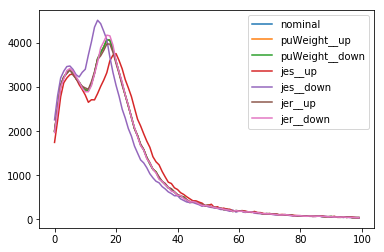

In [182]:
for k, v in vr.items():
    plt.plot(v["contents"], label=k)
plt.legend()

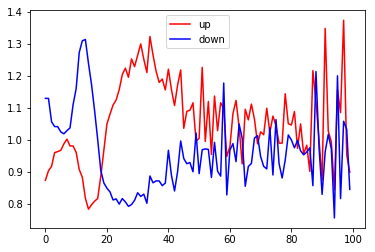

In [133]:
plt.plot(np.array(rr["jes__up"]["contents"]) / np.array(rr["nominal"]["contents"]), label="up", color="red")
plt.plot(np.array(rr["jes__down"]["contents"]) / np.array(rr["nominal"]["contents"]), label="down", color="blue")
plt.legend()

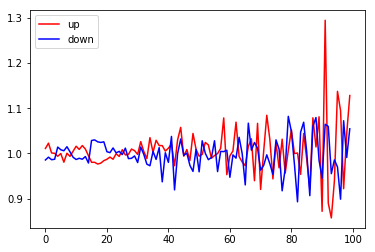

In [134]:
plt.plot(np.array(rr["jer__up"]["contents"]) / np.array(rr["nominal"]["contents"]), label="up", color="red")
plt.plot(np.array(rr["jer__down"]["contents"]) / np.array(rr["nominal"]["contents"]), label="down", color="blue")
plt.legend()

In [9]:
def midpoints(arr):
    return arr[:-1] - np.diff(arr)/2.0

In [10]:
def plot_hist_step(edges, contents, errors, kwargs_step={}, kwargs_errorbar={}):
    line = plt.step(edges[:-1], contents, where="pre", **kwargs_step)
    plt.errorbar(midpoints(edges), contents, errors, lw=0, elinewidth=1, color=line[0].get_color(), **kwargs_errorbar)

In [11]:
def load_hist(hist_dict):
    return {
        "edges": np.array(hist_dict["edges"]),
        "contents": np.array(hist_dict["contents"]),
        "contents_w2": np.array(hist_dict["contents_w2"]),
    }

In [13]:
xsw_dy = 5765.4 * int_lumi / res_dy["gen_sumweights"]
xsw_ggh = 0.009605 * int_lumi / res_ggh["gen_sumweights"]
xsw_ttjets_dl = 85.656 * int_lumi / res_ttjets_dl["gen_sumweights"]

In [14]:
res_ggh.keys()

dict_keys(['cache_metadata', 'num_events', 'baseline', 'gen_sumweights'])

In [15]:
def plot_hist_ratio(hists_mc, hist_data):
    plt.figure(figsize=(4,4), dpi=100)

    ax1 = plt.axes([0.0, 0.23, 1.0, 0.8])
       
    hmc_tot = np.zeros_like(hist_data["contents"])
    hmc_tot2 = np.zeros_like(hist_data["contents"])
    for h in hists_mc:
        plot_hist_step(h["edges"], hmc_tot + h["xsw"]*h["contents"], hmc_tot2 + h["xsw"]*np.sqrt(h["contents_w2"]), kwargs_step={"label": h.get("label", None)})
        hmc_tot += h["xsw"]*h["contents"]
        hmc_tot2 += h["xsw"]*h["contents_w2"]
#    plot_hist_step(h["edges"], hmc_tot, np.sqrt(hmc_tot2), kwargs_step={"color": "gray", "label": None})
    plt.errorbar(midpoints(hist_data["edges"]), hist_data["contents"], np.sqrt(hist_data["contents_w2"]), marker="o", lw=0, elinewidth=1.0, color="black", ms=3, label="data")
    
    plt.yscale("log")
    plt.ylim(1e-2, 10*np.max(hist_data["contents"]))
    
    #ax1.get_yticklabels()[-1].remove()
    
    ax2 = plt.axes([0.0, 0.0, 1.0, 0.16], sharex=ax1)

    ratio = hist_data["contents"] / hmc_tot
    ratio_err = np.sqrt(hist_data["contents_w2"]) /hmc_tot
    ratio[np.isnan(ratio)] = 0

    plt.errorbar(midpoints(hist_data["edges"]), ratio, ratio_err, marker="o", lw=0, elinewidth=1, ms=3, color="black")
    plt.ylim(0.5, 1.5)
    plt.axhline(1.0, color="black")
    return ax1, ax2

def load_and_plot(hn, weight):
    h1 = load_hist(res_dy[hn][weight])
    h2 = load_hist(res_ggh[hn][weight])
    h3 = load_hist(res_ttjets_dl[hn][weight])
    h4 = load_hist(res_ww[hn][weight])
    h5 = load_hist(res_wz[hn][weight])
    h6 = load_hist(res_zz[hn][weight])
    
    
    hd = load_hist(res_data[hn]["nominal"])
    if hn == "hist_inv_mass_d":
        msk = (hd["edges"][:-1] > 120) & (hd["edges"][:-1] < 131)
        hd["contents"][msk] = 0
        hd["contents_w2"][msk] = 0
    for h in [h1, h2, h3, h4, h5, h6, hd]:
        h["contents"][0] = 0
    h1["xsw"] = xsw_dy
    h1["label"] = "DY"
    
    h2["xsw"] = xsw_ggh
    h2["label"] = "ggH"
    
    h3["xsw"] = xsw_ttjets_dl
    h3["label"] = "tt"
    
    h_vv = {}
    h_vv["edges"] = h4["edges"]
    h_vv["contents"] = xsw_ww * h4["contents"] + xsw_wz * h5["contents"] + xsw_zz * h6["contents"] 
    h_vv["contents_w2"] = xsw_ww * h4["contents_w2"] + xsw_wz * h5["contents_w2"] + xsw_zz * h6["contents_w2"] 
    h_vv["label"] = "VV"
    h_vv["xsw"] = 1.0
    
    a1, a2 = plot_hist_ratio([h2, h_vv, h3, h1], hd)
    a1.text(0.01,0.99, r"CMS internal, $\int L = {0:.1f}\ fb^{{-1}}$ (2017)".format(int_lumi/1000.0),
        horizontalalignment='left', verticalalignment='top', transform=a1.transAxes
    )
    handles, labels = a1.get_legend_handles_labels()
    a1.legend(handles[::-1], labels[::-1], frameon=False)
    return a1, a2

In [20]:
a1, a2 = load_and_plot("hist__dnn_presel__phi_mmjj", "nominal")
#a1.set_xlim(125,150)
#a1.set_yscale("linear")

KeyError: 'hist__dnn_presel__phi_mmjj'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Number of events / bin')

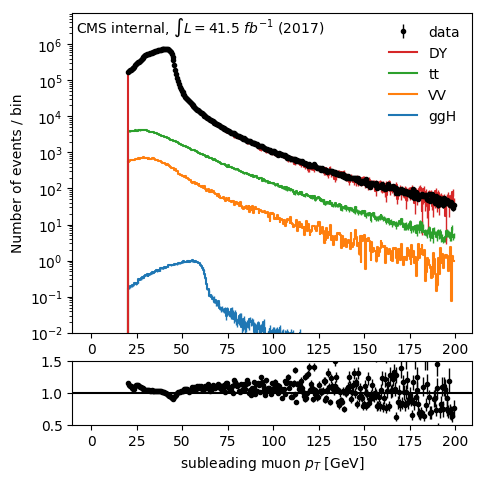

In [107]:
a1, a2 = load_and_plot("hist_mu1_pt", "puWeight")
a2.set_xlabel("subleading muon $p_T$ [GeV]")
a1.set_ylabel("Number of events / bin")
#a1.set_yscale("linear")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, 'Number of events / bin')

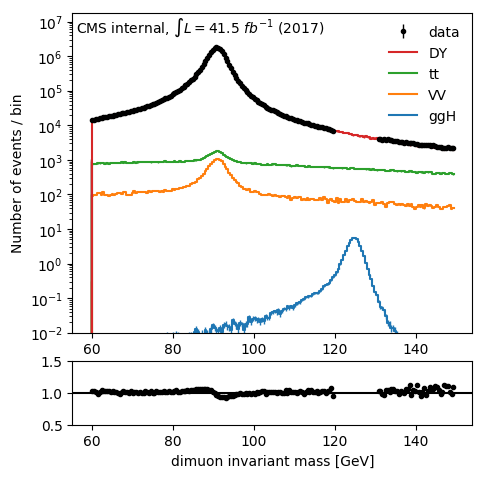

In [114]:
a1, a2 = load_and_plot("hist_inv_mass_d", "puWeight")
#a1.set_yscale("linear")
a2.set_xlabel("dimuon invariant mass [GeV]")
a1.set_ylabel("Number of events / bin")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


(0, 50)

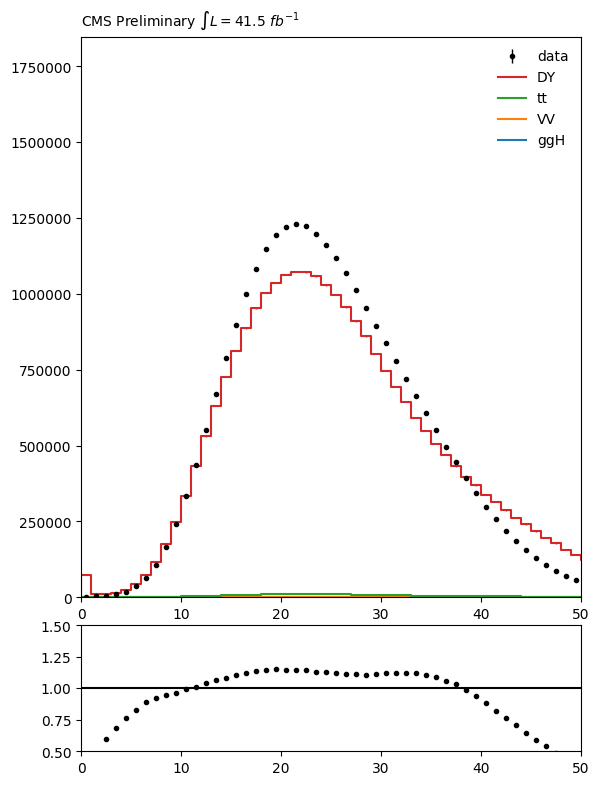

In [61]:
a1, a2 = load_and_plot("hist_npvs_d", "nominal")
a1.set_yscale("linear")
a1.set_xlim(0,50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


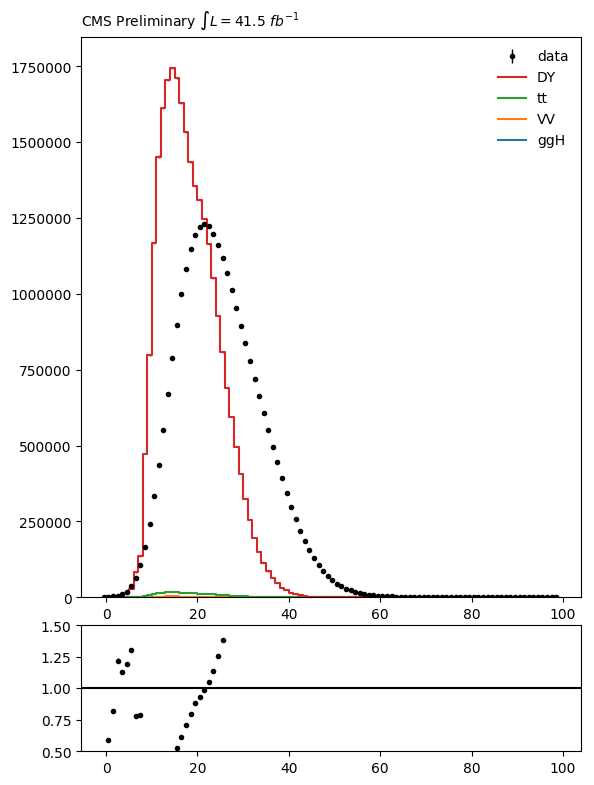

In [62]:
a1, a2 = load_and_plot("hist_npvs_d", "puWeight")
a1.set_yscale("linear")
#a1.set_xlim(60,80)

<ErrorbarContainer object of 3 artists>

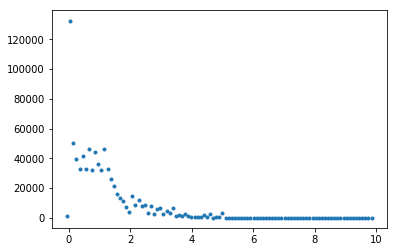

In [39]:
h = load_hist(res_ggh["hist_puweight"])
plt.errorbar(midpoints(h["edges"]), h["contents"], np.sqrt(h["contents_w2"]), lw=0, elinewidth=1, marker=".")
#plt.yscale("log")